In [85]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time

In [86]:
# Opening file, reading, eliminating whitespaces, and splitting by '\n', which in turn creates list
labels = open("obj.names").read().strip().split('\n')  # list of class names

# # Check point
print(labels)

['license_plate']


In [87]:
# Defining paths to the weights and configuration file with model of Neural Network
weights_path = "yolov4-obj.weights"
configuration_path = "yolov4-obj.cfg"

# Setting minimum probability to eliminate weak predictions
probability_minimum = 0.5

# Setting threshold for non maximum suppression
threshold = 0.3

In [88]:
network = cv2.dnn.readNetFromDarknet(configuration_path, weights_path)

# Getting names of all layers
layers_names_all = network.getLayerNames()  # list of layers names

# # Check point
print(layers_names_all)

('conv_0', 'bn_0', 'mish_1', 'conv_1', 'bn_1', 'mish_2', 'conv_2', 'bn_2', 'mish_3', 'identity_3', 'conv_4', 'bn_4', 'mish_5', 'conv_5', 'bn_5', 'mish_6', 'conv_6', 'bn_6', 'mish_7', 'shortcut_7', 'conv_8', 'bn_8', 'mish_9', 'concat_9', 'conv_10', 'bn_10', 'mish_11', 'conv_11', 'bn_11', 'mish_12', 'conv_12', 'bn_12', 'mish_13', 'identity_13', 'conv_14', 'bn_14', 'mish_15', 'conv_15', 'bn_15', 'mish_16', 'conv_16', 'bn_16', 'mish_17', 'shortcut_17', 'conv_18', 'bn_18', 'mish_19', 'conv_19', 'bn_19', 'mish_20', 'shortcut_20', 'conv_21', 'bn_21', 'mish_22', 'concat_22', 'conv_23', 'bn_23', 'mish_24', 'conv_24', 'bn_24', 'mish_25', 'conv_25', 'bn_25', 'mish_26', 'identity_26', 'conv_27', 'bn_27', 'mish_28', 'conv_28', 'bn_28', 'mish_29', 'conv_29', 'bn_29', 'mish_30', 'shortcut_30', 'conv_31', 'bn_31', 'mish_32', 'conv_32', 'bn_32', 'mish_33', 'shortcut_33', 'conv_34', 'bn_34', 'mish_35', 'conv_35', 'bn_35', 'mish_36', 'shortcut_36', 'conv_37', 'bn_37', 'mish_38', 'conv_38', 'bn_38', 'mish

In [89]:
print(network.getUnconnectedOutLayers())


[327 353 379]


In [90]:
# Getting only output layers names that we need from YOLO algorithm
layers_names_output = [layers_names_all[i - 1] for i in network.getUnconnectedOutLayers()]
# list of layers' names


# Check point
print(layers_names_output)  

['yolo_139', 'yolo_150', 'yolo_161']


In [91]:
# Our image initially is in RGB format
# But now we open it in BGR format as function 'cv2.imread' opens it so
image_input = cv2.imread("porshe.jpg")

# Getting image shape
image_input_shape = image_input.shape

# Check point
print(image_input_shape) 

(1280, 1024, 3)


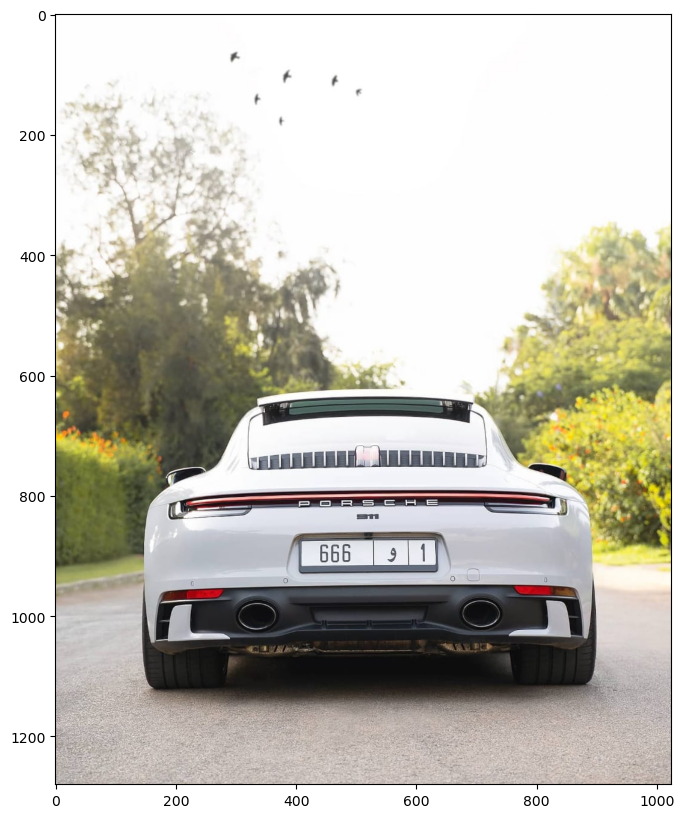

In [92]:
# Showing RGB image but firstly converting it from BGR format
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.imshow(cv2.cvtColor(image_input, cv2.COLOR_BGR2RGB))
plt.show()

In [93]:
blob = cv2.dnn.blobFromImage(image_input, 1 / 255.0, (416, 416), swapRB=True, crop=False)

# Check point
print(image_input.shape)  
print(blob.shape)  

(1280, 1024, 3)
(1, 3, 416, 416)


(416, 416, 3)


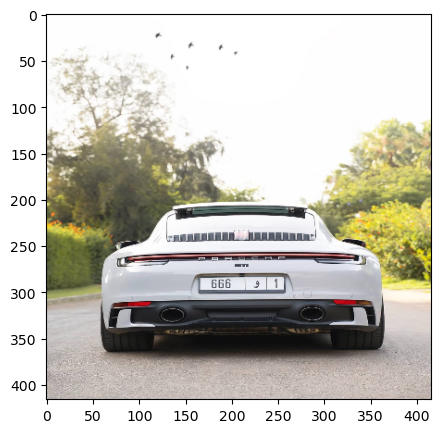

In [94]:
# Check point
# Slicing blob and transposing to make channels come at the end
blob_to_show = blob[0, :, :, :].transpose(1, 2, 0)
print(blob_to_show.shape)  # (416, 416, 3)

# Showing 'blob_to_show'
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 5.0)
plt.imshow(blob_to_show)
plt.show()

In [95]:
# Calculating at the same time, needed time for forward pass
network.setInput(blob)  # setting blob as input to the network
start = time.time()
output_from_network = network.forward(layers_names_output)
end = time.time()

# Showing spent time for forward pass
print('YOLO v4 took {:.3f} seconds'.format(end - start))

YOLO v4 took 1.935 seconds


In [96]:
# Check point
print(type(output_from_network))  # <class 'list'>
print(type(output_from_network[0]))  # <class 'numpy.ndarray'>

<class 'tuple'>
<class 'numpy.ndarray'>


In [97]:
# Seed the generator - every time we run the code it will generate by the same rules
# In this way we can keep specific colour the same for every class
np.random.seed(42)
# randint(low, high=None, size=None, dtype='l')
colours = np.random.randint(0, 255, size=(len(labels), 3), dtype='uint8')

# Check point
print(colours.shape)  
print(colours[0])  

(1, 3)
[102 220 225]


In [98]:
# Preparing lists for detected bounding boxes, obtained confidences and class's number
bounding_boxes = []
confidences = []
class_numbers = []

In [99]:
# Getting spacial dimension of input image
h, w = image_input_shape[:2]  # Slicing from tuple only first two elements

# Check point
print(h, w)  

1280 1024


In [100]:
for result in output_from_network:
    # Going through all detections from current output layer
    for detection in result:
        # Getting class for current object
        scores = detection[5:]
        class_current = np.argmax(scores)

        # Getting confidence (probability) for current object
        confidence_current = scores[class_current]

        # Eliminating weak predictions by minimum probability
        if confidence_current > probability_minimum:
            # Scaling bounding box coordinates to the initial image size
            # YOLO data format keeps center of detected box and its width and height
            # That is why we can just elementwise multiply them to the width and height of the image
            box_current = detection[0:4] * np.array([w, h, w, h])

            # From current box with YOLO format getting top left corner coordinates
            # that are x_min and y_min
            x_center, y_center, box_width, box_height = box_current.astype('int')
            x_min = int(x_center - (box_width / 2))
            y_min = int(y_center - (box_height / 2))

            # Adding results into prepared lists
            bounding_boxes.append([x_min, y_min, int(box_width), int(box_height)])
            confidences.append(float(confidence_current))
            class_numbers.append(class_current)

In [101]:
# It is needed to make sure the data type of the boxes is 'int'
# and the type of the confidences is 'float'
# https://github.com/opencv/opencv/issues/12789
results = cv2.dnn.NMSBoxes(bounding_boxes, confidences, probability_minimum, threshold)

# Check point
# Showing labels of the detected objects
for i in range(len(class_numbers)):
    print(labels[int(class_numbers[i])])

# Saving found labels
with open('found_labels.txt', 'w') as f:
    for i in range(len(class_numbers)):
        f.write(labels[int(class_numbers[i])])

license_plate
license_plate


In [102]:
#Checking if there is at least one detected object
if len(results) > 0:
    # Going through indexes of results
    for i in results.flatten():
        # Getting current bounding box coordinates
        x_min, y_min = bounding_boxes[i][0], bounding_boxes[i][1]
        box_width, box_height = bounding_boxes[i][2], bounding_boxes[i][3]

        # Preparing colour for current bounding box
        colour_box_current = [int(j) for j in colours[class_numbers[i]]]

        # Drawing bounding box on the original image
        cv2.rectangle(image_input, (x_min, y_min), (x_min + box_width, y_min + box_height),
                      colour_box_current, 2)

        # Preparing text with label and confidence for current bounding box
        text_box_current = '{} : {:.2f}%'.format(labels[int(class_numbers[i])], confidences[i])

        # Putting text with label and confidence on the original image
        cv2.putText(image_input, text_box_current, (x_min, y_min - 7), cv2.FONT_HERSHEY_SIMPLEX,0.5, colour_box_current, 2)

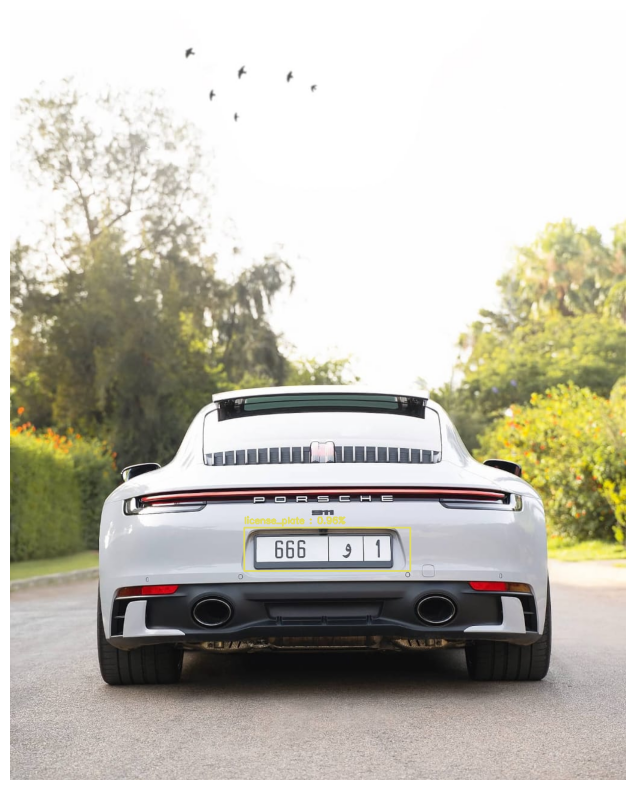

In [103]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.imshow(cv2.cvtColor(image_input, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()